In [13]:
# Copyright (c) Meta Platforms, Inc. and affiliates. All rights reserved.

# Render DensePose 

DensePose refers to dense human pose representation: https://github.com/facebookresearch/DensePose. 
In this tutorial, we provide an example of using DensePose data in PyTorch3D.

This tutorial shows how to:
- load a mesh and textures from densepose `.mat` and `.pkl` files
- set up a renderer 
- render the mesh 
- vary the rendering settings such as lighting and camera position

## Import modules

Ensure `torch` and `torchvision` are installed. If `pytorch3d` is not installed, install it using the following cell:

In [14]:
import os
import sys
import torch
need_pytorch3d=False
try:
    import pytorch3d
except ModuleNotFoundError:
    need_pytorch3d=True
if need_pytorch3d:
    if torch.__version__.startswith(("1.13.", "2.0.")) and sys.platform.startswith("linux"):
        # We try to install PyTorch3D via a released wheel.
        pyt_version_str=torch.__version__.split("+")[0].replace(".", "")
        version_str="".join([
            f"py3{sys.version_info.minor}_cu",
            torch.version.cuda.replace(".",""),
            f"_pyt{pyt_version_str}"
        ])
        !pip install fvcore iopath
        !pip install --no-index --no-cache-dir pytorch3d -f https://dl.fbaipublicfiles.com/pytorch3d/packaging/wheels/{version_str}/download.html
    else:
        # We try to install PyTorch3D from source.
        !pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

In [15]:
# We also install chumpy as it is needed to load the SMPL model pickle file.
!pip install chumpy

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [16]:
import os
import torch
import matplotlib.pyplot as plt
import numpy as np

# libraries for reading data from files
from scipy.io import loadmat
from PIL import Image
import pickle

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras, 
    PointLights, 
    DirectionalLights, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    TexturesUV
)

# add path for demo utils functions 
import sys
import os
sys.path.append(os.path.abspath(''))

## Load the SMPL model

#### Download the SMPL model
- Go to https://smpl.is.tue.mpg.de/download.php and sign up.
- Download SMPL for Python Users and unzip.
- Copy the file male template file **'models/basicModel_m_lbs_10_207_0_v1.0.0.pkl'** to the data/DensePose/ folder.
   - rename the file to **'smpl_model.pkl'** or rename the string where it's commented below
   
If running this notebook using Google Colab, run the following cell to fetch the texture and UV values and save it at the correct path.

In [17]:
# Texture image
!wget -P data/DensePose https://raw.githubusercontent.com/facebookresearch/DensePose/master/DensePoseData/demo_data/texture_from_SURREAL.png

# UV_processed.mat
!wget https://dl.fbaipublicfiles.com/densepose/densepose_uv_data.tar.gz
!tar xvf densepose_uv_data.tar.gz -C data/DensePose
!rm densepose_uv_data.tar.gz

'wget' �����ڲ����ⲿ���Ҳ���ǿ����еĳ���
���������ļ���


'wget' �����ڲ����ⲿ���Ҳ���ǿ����еĳ���
���������ļ���
tar: Error opening archive: Failed to open 'densepose_uv_data.tar.gz'
'rm' �����ڲ����ⲿ���Ҳ���ǿ����еĳ���
���������ļ���


Load our texture UV data and our SMPL data, with some processing to correct data values and format.

In [18]:
# Setup
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")
    
# Set paths
DATA_DIR = "./data"
data_filename = os.path.join(DATA_DIR, "DensePose/UV_Processed.mat")
tex_filename = os.path.join(DATA_DIR,"DensePose/texture_from_SURREAL.png")
# rename your .pkl file or change this string
verts_filename = os.path.join(DATA_DIR, "DensePose/smpl_model.pkl")


# Load SMPL and texture data
with open(verts_filename, 'rb') as f:
    data = pickle.load(f, encoding='latin1') 
    v_template = torch.Tensor(data['v_template']).to(device) # (6890, 3)
ALP_UV = loadmat(data_filename)
with Image.open(tex_filename) as image:
    np_image = np.asarray(image.convert("RGB")).astype(np.float32)
tex = torch.from_numpy(np_image / 255.)[None].to(device)

verts = torch.from_numpy((ALP_UV["All_vertices"]).astype(int)).squeeze().to(device) # (7829,)
U = torch.Tensor(ALP_UV['All_U_norm']).to(device) # (7829, 1)
V = torch.Tensor(ALP_UV['All_V_norm']).to(device) # (7829, 1)
faces = torch.from_numpy((ALP_UV['All_Faces'] - 1).astype(int)).to(device)  # (13774, 3)
face_indices = torch.Tensor(ALP_UV['All_FaceIndices']).squeeze()  # (13774,)

C:\Users\chen1\AppData\Local\Temp\ipykernel_16700\2149450450.py:18: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  data = pickle.load(f, encoding='latin1')


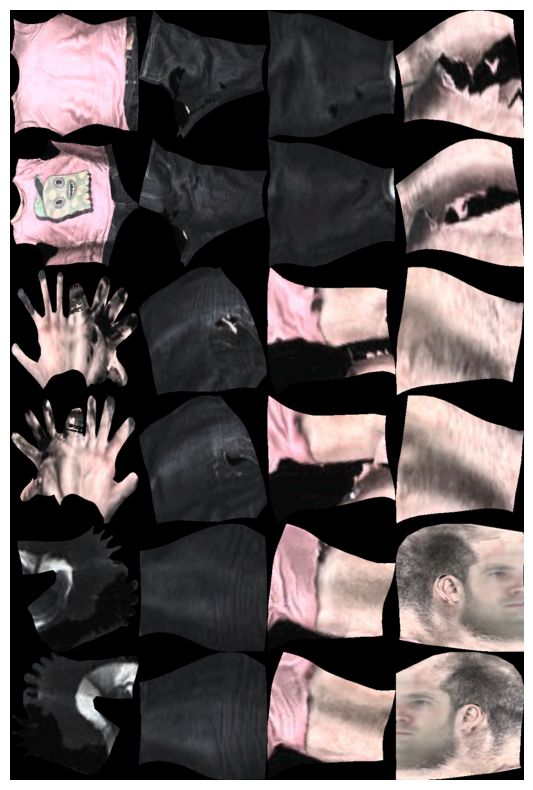

In [19]:
# Display the texture image
plt.figure(figsize=(10, 10))
plt.imshow(tex.squeeze(0).cpu())
plt.axis("off");

In DensePose, the body mesh is split into 24 parts. In the texture image, we can see the 24 parts are separated out into individual (200, 200) images per body part.  The convention in DensePose is that each face in the mesh is associated with a body part (given by the face_indices tensor above). The vertex UV values (in the range [0, 1]) for each face are specific to the (200, 200) size texture map for the part of the body that the mesh face corresponds to. We cannot use them directly with the entire texture map. We have to offset the vertex UV values depending on what body part the associated face corresponds to.

In [20]:
# Map each face to a (u, v) offset
offset_per_part = {}
already_offset = set()
cols, rows = 4, 6
for i, u in enumerate(np.linspace(0, 1, cols, endpoint=False)):
    for j, v in enumerate(np.linspace(0, 1, rows, endpoint=False)):
        part = rows * i + j + 1  # parts are 1-indexed in face_indices
        offset_per_part[part] = (u, v)

U_norm = U.clone()
V_norm = V.clone()

# iterate over faces and offset the corresponding vertex u and v values
for i in range(len(faces)):
    face_vert_idxs = faces[i]
    part = face_indices[i]
    offset_u, offset_v = offset_per_part[int(part.item())]
    
    for vert_idx in face_vert_idxs:   
        # vertices are reused, but we don't want to offset multiple times
        if vert_idx.item() not in already_offset:
            # offset u value
            U_norm[vert_idx] = U[vert_idx] / cols + offset_u
            # offset v value
            # this also flips each part locally, as each part is upside down
            V_norm[vert_idx] = (1 - V[vert_idx]) / rows + offset_v
            # add vertex to our set tracking offsetted vertices
            already_offset.add(vert_idx.item())

# invert V values
V_norm = 1 - V_norm

In [21]:
# create our verts_uv values
verts_uv = torch.cat([U_norm[None],V_norm[None]], dim=2) # (1, 7829, 2)

# There are 6890 xyz vertex coordinates but 7829 vertex uv coordinates. 
# This is because the same vertex can be shared by multiple faces where each face may correspond to a different body part.  
# Therefore when initializing the Meshes class,
# we need to map each of the vertices referenced by the DensePose faces (in verts, which is the "All_vertices" field)
# to the correct xyz coordinate in the SMPL template mesh.
# verts = torch.from_numpy((ALP_UV["All_vertices"]).astype(int)).squeeze().to(device) # (7829,)
vert_i = verts-1
# v_template_extended = v_template[verts-1][None]# (1, 7829, 3)
v_template_extended = v_template[vert_i.type(torch.long)][None]# (1, 7829, 3)

### Create our textured mesh 

**Meshes** is a unique datastructure provided in PyTorch3D for working with batches of meshes of different sizes.

**TexturesUV** is an auxiliary datastructure for storing vertex uv and texture maps for meshes.

In [22]:

print(v_template_extended.dtype,faces.dtype,verts_uv.dtype,tex.dtype)
# print(faces)
faces  = faces.type(torch.long)
# verts_uv = verts_uv.type(torch.long)
texture = TexturesUV(maps=tex, faces_uvs=faces[None], verts_uvs=verts_uv)

mesh = Meshes(verts = v_template_extended,  faces= faces[None], textures = texture)



torch.float32 torch.int32 torch.float32 torch.float32


## Create a renderer

In [23]:
# Initialize a camera.
# World coordinates +Y up, +X left and +Z in.
R, T = look_at_view_transform(2.7, 0, 0) 
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

# Define the settings for rasterization and shading. Here we set the output image to be of size
# 512x512. As we are rendering images for visualization purposes only we will set faces_per_pixel=1
# and blur_radius=0.0. 
raster_settings = RasterizationSettings(
    image_size=512, 
    blur_radius=0.0, 
    faces_per_pixel=1, 
    clip_barycentric_coords=True,
)

# Place a point light in front of the person. 
lights = PointLights(device=device, location=[[0.0, 0.0, 2.0]])

# Create a Phong renderer by composing a rasterizer and a shader. The textured Phong shader will 
# interpolate the texture uv coordinates for each vertex, sample from a texture image and 
# apply the Phong lighting model
renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=SoftPhongShader(
        device=device, 
        cameras=cameras,
        lights=lights
    )
)

Render the textured mesh we created from the SMPL model and texture map.

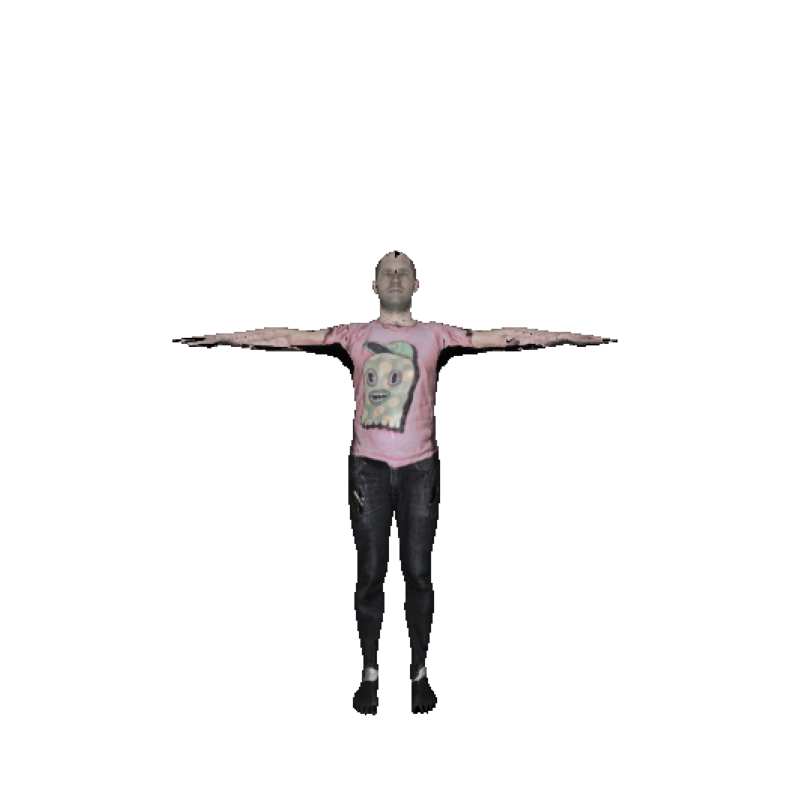

In [24]:
# print(mesh)
images = renderer(mesh)
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off");

### Different view and lighting of the body

We can also change many other settings in the rendering pipeline. Here we:

- change the **viewing angle** of the camera
- change the **position** of the point light

In [25]:
# Rotate the person by increasing the elevation and azimuth angles to view the back of the person from above. 
R, T = look_at_view_transform(2.7, 10, 180)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

# Move the light location so the light is shining on the person's back.  
lights.location = torch.tensor([[2.0, 2.0, -2.0]], device=device)

# Re render the mesh, passing in keyword arguments for the modified components.
images = renderer(mesh, lights=lights, cameras=cameras)

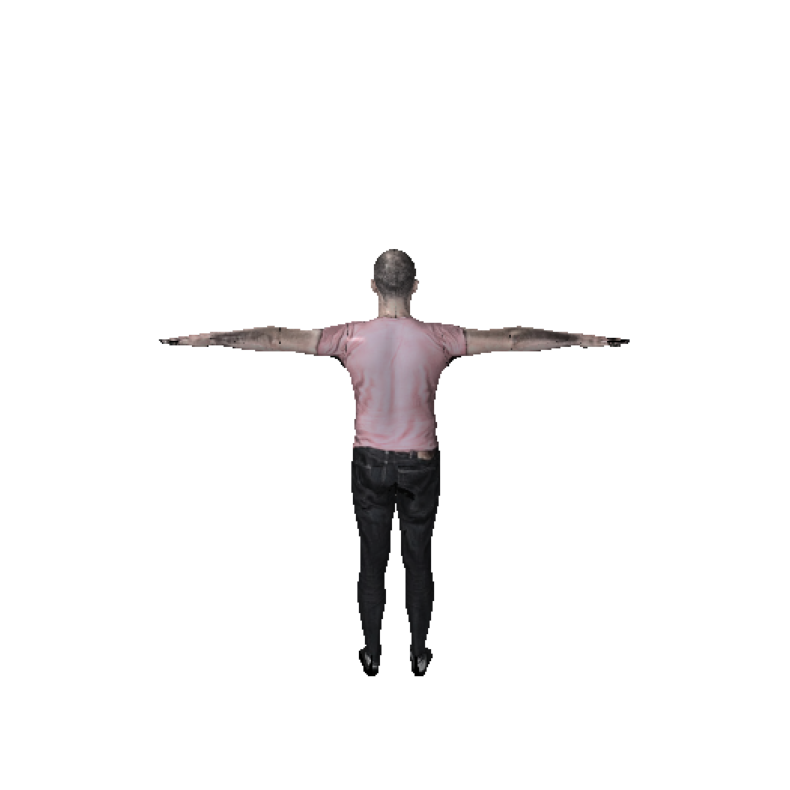

In [26]:
plt.figure(figsize=(10, 10))
plt.imshow(images[0, ..., :3].cpu().numpy())
plt.axis("off");

## Conclusion
In this tutorial, we've learned how to construct a **textured mesh** from **DensePose model and uv data**, as well as initialize a **Renderer** and change the viewing angle and lighting of our rendered mesh.